In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
import matplotlib.patches as mpatches 

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import joblib

In [2]:
df = pd.read_csv("wdbc.csv")
df

,Ob,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave.points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave.points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


There are thirty columns in the table, so in Feature selection, SelectKBest is used to select the best features to reduce data dimension. From the results, the top 10 features are radius_mean, perimeter_mean, area_mean, concavity_mean, concave.points_mean, radius_worst, perimeter_worst, area_worst, concavity_worst and  concave.points_worst.

Our models will several feature combinations to train and test the results.

(1)cols0: all the 30 feature combinations.

(2)cols1: 10 feature combinations using selectKBest.

(3)cols2: 5 mean feature combinations:radius_mean,perimeter_mean,area_mean,concave.points_mean and concavity_mean.

(4)cols3: 6 features combinations: perimeter_worst,perimeter_mean,area_worst,area_mean,concave.points_mean and concave.points_worst.

(5)cols4: 4 features combinations: perimeter_worst,perimeter_mean,area_worst and area_mean.

(6)cols5: 4 features combinations: area_worst,area_mean,concave.points_mean and concave.points_worst.

(7)cols6: 2 features combinations: area_mean and concave.points_mean.

In [3]:
cols0 = df.columns.values.tolist()
cols0 = cols0[2:32]
cols1 = ['perimeter_worst','perimeter_mean','area_worst','area_mean','concave.points_mean','concave.points_worst',
        'radius_worst','radius_mean','concavity_worst','concavity_mean']
cols2 = ["radius_mean","perimeter_mean","area_mean",'concave.points_mean','concavity_mean']
cols3 = ['perimeter_worst','perimeter_mean','area_worst','area_mean','concave.points_mean','concave.points_worst']
cols4 = ['perimeter_worst','perimeter_mean','area_worst','area_mean']
cols5 = ['area_worst','area_mean','concave.points_mean','concave.points_worst']
cols6 = ['area_mean','concave.points_mean']
cols =[cols0,cols1,cols2,cols3,cols4,cols5,cols6]

## Clean the data

(1)The data type of tag diagnosis is character, "B" indicates benign and "m" indicates malignant. Use labelencoder to digitize it and encode the tag value as 0,1, so that it can be used as the training tag of the model.

(2)Every original data set may have differences in orders in dimension and different magnitudes. If we do not make modifications to them and use the original value directly, this will highlight the role of the features with higher numerical value in the analysis and weaken the role of the features with lower numerical value. To ensure the reliability of our results, we need to standardize the original data. After standardization, every feature has a mean of 0 and a standard deviation of 1.

In [4]:
def clean_data(df1):
    #df1 = data.loc[:,cols]
    encoder = preprocessing.LabelEncoder().fit(df1['diagnosis'])
    df1['diagnosis'] = encoder.transform(df1['diagnosis'])
    df1 = df1.dropna()
    X = df1.drop(['diagnosis'],axis = 1)
    y = df1['diagnosis']
    #standarization
    X_mean=X.mean(axis=0)
    X_std=X.std(axis=0)
    X= (X-X_mean)/X_std
    df2 = pd.concat([y,X],axis=1)
    return df2   

In [5]:
dataset = clean_data(df)
dataset

,diagnosis,Ob,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave.points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave.points_worst,symmetry_worst,fractal_dimension_worst
0,1,-0.236197,1.096100,-2.071512,1.268817,0.983510,1.567087,3.280628,2.650542,2.530249,...,1.885031,-1.358098,2.301575,1.999478,1.306537,2.614365,2.107672,2.294058,2.748204,1.935312
1,1,-0.236196,1.828212,-0.353322,1.684473,1.907030,-0.826235,-0.486643,-0.023825,0.547662,...,1.804340,-0.368879,1.533776,1.888827,-0.375282,-0.430066,-0.146620,1.086129,-0.243675,0.280943
2,1,0.431362,1.578499,0.455786,1.565126,1.557513,0.941382,1.052000,1.362280,2.035440,...,1.510541,-0.023953,1.346291,1.455004,0.526944,1.081980,0.854222,1.953282,1.151242,0.201214
3,1,0.431741,-0.768233,0.253509,-0.592166,-0.763792,3.280667,3.399917,1.914213,1.450431,...,-0.281217,0.133866,-0.249720,-0.549538,3.391291,3.889975,1.987839,2.173873,6.040726,4.930672
4,1,0.431821,1.748758,-1.150804,1.775011,1.824624,0.280125,0.538866,1.369806,1.427237,...,1.297434,-1.465481,1.337363,1.219651,0.220362,-0.313119,0.612640,0.728618,-0.867590,-0.396751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,-0.235524,2.109139,0.720838,2.058974,2.341795,1.040926,0.218868,1.945573,2.318924,...,1.899514,0.117596,1.751022,2.013529,0.378033,-0.273077,0.663928,1.627719,-1.358963,-0.708467
565,1,-0.235522,1.703356,2.083301,1.614511,1.722326,0.102368,-0.017817,0.692434,1.262558,...,1.535369,2.045599,1.420690,1.493644,-0.690623,-0.394473,0.236365,0.733182,-0.531387,-0.973122
566,1,-0.235520,0.701667,2.043775,0.672084,0.577445,-0.839745,-0.038646,0.046547,0.105684,...,0.560868,1.373645,0.578492,0.427529,-0.808876,0.350427,0.326479,0.413705,-1.103578,-0.318129
567,1,-0.235518,1.836725,2.334403,1.980781,1.733693,1.524426,3.269267,3.294046,2.656528,...,1.959515,2.235958,2.301575,1.651717,1.429169,3.901415,3.194794,2.287972,1.917396,2.217684


We separate the dataset into the test data set and the train data set. The train data set takes up 70% of the entire data, and the test data set takes up the rest 30%.

In [6]:
train,test=train_test_split(dataset,test_size=.3,random_state=42)

X_train=train.drop(['diagnosis'],axis = 1)
y_train=train['diagnosis']

X_test=test.drop(['diagnosis'],axis = 1)
y_test=test['diagnosis']

In [7]:
X_train[cols5]

,area_worst,area_mean,concave.points_mean,concave.points_worst
149,-0.271680,-0.198597,-0.918210,-0.827846
124,-0.436428,-0.288108,-0.539114,-0.377687
421,-0.125375,0.003441,0.362882,-0.057905
195,-0.491753,-0.393531,-0.648126,-0.490721
545,-0.264831,-0.232128,-0.631117,-0.652133
...,...,...,...,...
71,-1.047117,-1.167583,-0.520558,-1.015424
106,-0.630331,-0.688773,-0.362580,0.109440
270,-0.344218,-0.063337,-1.099640,-1.236472
435,-0.019817,-0.157394,0.404889,1.035925


In [112]:
X_test[cols5]

,area_worst,area_mean,concave.points_mean,concave.points_worst
204,-0.355986,-0.491566,-0.275989,-0.199388
70,1.730754,1.350076,0.788366,0.978115
131,0.483733,0.267142,0.823415,0.559752
431,-0.640693,-0.531633,-0.539371,-0.622315
540,-0.742562,-0.716053,-0.592203,-0.691079
...,...,...,...,...
69,-0.572019,-0.433029,-0.522620,-0.848688
542,-0.095165,0.038961,-0.480613,-0.077682
176,-0.861293,-1.001634,-0.303049,-0.235899
501,-0.162610,-0.167624,0.481172,0.570401


## General functions

plot_confusionmatrix：plots the confusion matrix of a classifier

check_column_score：sorts the training average accuracy of all the column combinations by cross validation, then show the top n column combinations and their train score and test score. 

In [8]:
def plot_confusionmatrix(model,Xt,yt):
    """
    Plots the confusion matrix of a classifier
    model:trainded classifiers
    Xt:test data
    yt:the true value of test 
    """
    y_model = model.predict(Xt) #the predicted value of test
    mat = confusion_matrix(yt,y_model) #compare the true value and the predicted value
    mat_df = pd.DataFrame(mat)
    #plot the confusion matrix
    sns.heatmap(mat,square = True,annot= True, fmt = 'd', cmap="YlGnBu", cbar = False)
    plt.xlabel("Predicted value")
    plt.ylabel("True value")    
    plt.title("confusion matrix")
    
def check_column_score(clf):
    """
    show the top n column combinations and their training score and testing score.
    clf:trained classifiers     
    """
    D = {}
    #get the training average accuracy of all the column combinations by cross_validation
    for i in range(len(cols)):
        col = cols[i]
        D[i] = cross_val_score(clf,X_train[col],y_train,cv=5).mean()
    L = list(D.items())
    #sort the training accuracy
    L.sort(key = lambda x:x[1],reverse = True)
    #get the top n column combinations
    best = L[0:7]
    for key,value in best:
        print(str(cols[key])+":")
        col = cols[key]
        clf.fit(X_train[col],y_train)
        j = clf.score(X_test[col],y_test).round(3)
        print(" Train score is:"+str(np.round(value,3)) + " --- Test score is:"+ str(j))    

## (a). **Logistic Regression**

We build a Logistic Regression Model and use all the possible feature combinations of this model to do the training and testing. We calculate the training and testing accuracies and order them by training accuracy.

In [10]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
check_column_score(LR)

['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave.points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave.points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave.points_worst', 'symmetry_worst', 'fractal_dimension_worst']:
 Train score is:0.975 --- Test score is:0.982
['perimeter_worst', 'perimeter_mean', 'area_worst', 'area_mean', 'concave.points_mean', 'concave.points_worst', 'radius_worst', 'radius_mean', 'concavity_worst', 'concavity_mean']:
 Train score is:0.947 --- Test score is:0.965
['perimeter_worst', 'perimeter_mean', 'area_worst', 'area_mean', 'concave.points_mean', 'concave.points_worst']:
 Train score is:0.937 --- Test score is:0.965
['area_worst', 'area_

We choose the features in cols5 and train the model based on those features. We also test the accuracy on the testing data set and use the function plot_confusionmatrix to display the confusion matrix.

0.9588235294117649


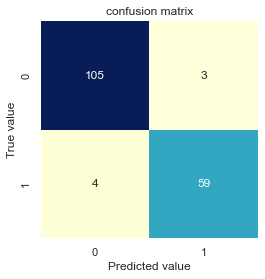

In [11]:
LR.fit(X_train[cols5], y_train)
cv_score_test = cross_val_score(LR, X_test[cols5], y_test, cv=10).mean()
print(cv_score_test)
plot_confusionmatrix(LR,X_test[cols5],y_test)

We store our trained linear regression model in .\models\LR.m and use it in webapp.

In [12]:
joblib.dump(LR, ".\\models\\LR.m") 

['.\\models\\LR.m']

## (b). **Decision Tree**

We build a Decision Tree Model and use all the possible feature combinations of this model to do the training and testing. We calculate the training and testing accuracies and order them by training accuracy.

In [13]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(max_depth = 12, criterion = 'entropy')
check_column_score(DT)

['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave.points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave.points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave.points_worst', 'symmetry_worst', 'fractal_dimension_worst']:
 Train score is:0.932 --- Test score is:0.953
['area_worst', 'area_mean', 'concave.points_mean', 'concave.points_worst']:
 Train score is:0.922 --- Test score is:0.947
['perimeter_worst', 'perimeter_mean', 'area_worst', 'area_mean', 'concave.points_mean', 'concave.points_worst']:
 Train score is:0.92 --- Test score is:0.953
['perimeter_worst', 'perimeter_mean', 'area_worst', 'area_mean', 'concave.points_mean', 'concave.points_worst', 'radius_worst',

We choose the features in cols5 and train the model based on those features. We also test the accuracy on the testing data set and use the function plot_confusionmatrix to display the confusion matrix.

0.9238562091503268


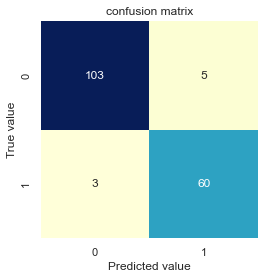

In [14]:
DT.fit(X_train[cols5], y_train)
cv_score_test = cross_val_score(DT, X_test[cols5], y_test, cv=10).mean()
print(cv_score_test)
plot_confusionmatrix(DT,X_test[cols5],y_test)

We store our trained Decision Tree model in models\DT.m and use it in webapp.

In [15]:
joblib.dump(DT, ".\\models\\DT.m") 

['.\\models\\DT.m']

## (c). **Neural Networks**

We build a Multilayer Perceptron Model and use all the possible feature combinations of this model to do the training and testing. We calculate the training and testing accuracies and order them by training accuracy.

In [15]:
MLP = MLPClassifier(solver='adam', activation = 'relu', alpha=1e-5,max_iter=3000,
                     hidden_layer_sizes= (18,18,18),random_state=1)

check_column_score(MLP)

['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave.points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave.points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave.points_worst', 'symmetry_worst', 'fractal_dimension_worst']:
 Train score is:0.977 --- Test score is:0.982
['area_worst', 'area_mean', 'concave.points_mean', 'concave.points_worst']:
 Train score is:0.942 --- Test score is:0.971
['perimeter_worst', 'perimeter_mean', 'area_worst', 'area_mean', 'concave.points_mean', 'concave.points_worst', 'radius_worst', 'radius_mean', 'concavity_worst', 'concavity_mean']:
 Train score is:0.932 --- Test score is:0.965
['perimeter_worst', 'perimeter_mean', 'area_worst', 'area_

We choose the features in cols5 and train the model based on those features. We also test the accuracy on the testing data set and use the function plot_confusionmatrix to display the confusion matrix.

0.9591503267973855


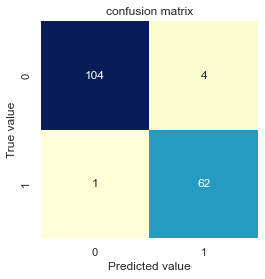

In [16]:
MLP.fit(X_train[cols5], y_train)
cv_score_test = cross_val_score(MLP, X_test[cols5], y_test, cv=10).mean()
print(cv_score_test)
plot_confusionmatrix(MLP,X_test[cols5],y_test)

We store our trained Multilayer Perceptron model in models\MLP.m and use it in webapp.

In [17]:
joblib.dump(MLP, ".\\models\\MLP.m") 

['.\\models\\MLP.m']

## (d). **Random Forest**

We build a Random Forest Model and use all the possible feature combinations of this model to do the training and testing. We calculate the training and testing accuracies and order them by training accuracy.

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
RF = RandomForestClassifier(n_estimators=100)
check_column_score(RF)

['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave.points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave.points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave.points_worst', 'symmetry_worst', 'fractal_dimension_worst']:
 Train score is:0.955 --- Test score is:0.965
['perimeter_worst', 'perimeter_mean', 'area_worst', 'area_mean', 'concave.points_mean', 'concave.points_worst', 'radius_worst', 'radius_mean', 'concavity_worst', 'concavity_mean']:
 Train score is:0.942 --- Test score is:0.953
['area_worst', 'area_mean', 'concave.points_mean', 'concave.points_worst']:
 Train score is:0.937 --- Test score is:0.965
['perimeter_worst', 'perimeter_mean', 'area_worst', 'area_

We choose the features in cols5 and train the model based on those features. We also test the accuracy on the testing data set and use the function plot_confusionmatrix to display the confusion matrix.

0.9529411764705884


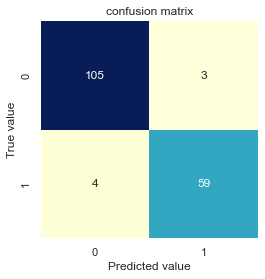

In [19]:
RF.fit(X_train[cols5], y_train)
cv_score_test = cross_val_score(RF, X_test[cols5], y_test, cv=10).mean()
print(cv_score_test)
plot_confusionmatrix(RF,X_test[cols5],y_test)

We store our trained Random Forest model in models\RF.m and use it in webapp.

In [20]:
joblib.dump(RF, ".\\models\\RF.m") 

['.\\models\\RF.m']

## (e). **SVM**

We build a Support Vector Machine Model and use all the possible feature combinations of this model to do the training and testing. We calculate the training and testing accuracies and order them by training accuracy.

In [21]:
SVM = SVC(kernel = 'rbf',C=1E6,gamma = 0.005)
check_column_score(SVM)  

['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave.points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave.points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave.points_worst', 'symmetry_worst', 'fractal_dimension_worst']:
 Train score is:0.972 --- Test score is:0.947
['area_worst', 'area_mean', 'concave.points_mean', 'concave.points_worst']:
 Train score is:0.947 --- Test score is:0.971
['perimeter_worst', 'perimeter_mean', 'area_worst', 'area_mean', 'concave.points_mean', 'concave.points_worst', 'radius_worst', 'radius_mean', 'concavity_worst', 'concavity_mean']:
 Train score is:0.94 --- Test score is:0.93
['perimeter_worst', 'perimeter_mean', 'area_worst', 'area_me

We choose the features in cols5 and train the model based on those features. We also test the accuracy on the testing data set and use the function plot_confusionmatrix to display the confusion matrix.

0.9594771241830065


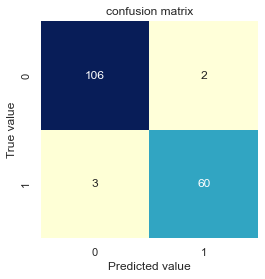

In [22]:
SVM.fit(X_train[cols5], y_train)
cv_score_test = cross_val_score(SVM, X_test[cols5], y_test, cv=10).mean()
print(cv_score_test)
plot_confusionmatrix(SVM,X_test[cols5],y_test)

We store our trained Support Vector Machine model in models\SVM.m and use it in webapp.

In [23]:
joblib.dump(SVM, ".\\models\\SVM.m") 

['.\\models\\SVM.m']

## (f). **Tensorflow** 

We build a Tensorflow Model in all the features. We calculate the training and testing accuracies and order them by training accuracy.

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
TF = tf.keras.models.Sequential([
    layers.Dense(100, input_shape = (30,), activation='relu'),
    layers.Dense(100,activation="sigmoid"),
    layers.Dense(10,activation="softmax"),
    layers.Dense(2)
])

In [10]:
TF.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               3100      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 22        
Total params: 14,232
Trainable params: 14,232
Non-trainable params: 0
_________________________________________________________________


Train TF model and plot the history of the accuracy on both the training and vailidation sets.

In [11]:
# ready for training!
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
TF.compile(optimizer ="adam",
              loss = loss_fn,
              metrics = ["accuracy"])
# train them 100 times.
history = TF.fit(X_train[cols0], y_train, epochs = 100, verbose=1)

Epoch 1/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6756 - accuracy: 0.7010
Epoch 2/100
13/13 [==============================] - 0s 880us/step - loss: 0.6088 - accuracy: 0.8719
Epoch 3/100
13/13 [==============================] - 0s 921us/step - loss: 0.5410 - accuracy: 0.9322
Epoch 4/100
13/13 [==============================] - 0s 924us/step - loss: 0.5031 - accuracy: 0.9523
Epoch 5/100
13/13 [==============================] - 0s 921us/step - loss: 0.4793 - accuracy: 0.9648
Epoch 6/100
13/13 [==============================] - 0s 997us/step - loss: 0.4608 - accuracy: 0.9724
Epoch 7/100
13/13 [==============================] - 0s 1ms/step - loss: 0.4455 - accuracy: 0.9799
Epoch 8/100
13/13 [==============================] - 0s 921us/step - loss: 0.4320 - accuracy: 0.9824
Epoch 9/100
13/13 [==============================] - 0s 921us/step - loss: 0.4190 - accuracy: 0.9849
Epoch 10/100
13/13 [==============================] - 0s 921us/step - loss: 0.4074 - accuracy: 

Plot the history of TF, including the training and validation performance.

[Text(0.5, 0, 'epoch'), Text(0, 0.5, 'training accuracy')]

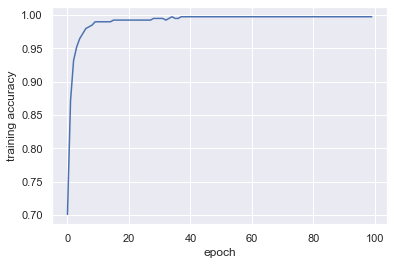

In [12]:
# plot the progress of the training over time:
plt.plot(history.history["accuracy"])
plt.gca().set(xlabel = "epoch", ylabel = "training accuracy")

We’ll test the model performance on unseen test data.

In [13]:
TF.evaluate(X_test[cols0], y_test, verbose = 2)

6/6 - 0s - loss: 0.1429 - accuracy: 0.9649


[0.14287850260734558, 0.9649122953414917]

##### My observations
(1)The validation accuracy of model stabilized between 70.64% and 99.75% during training.

(2)The highest validation accuracy is 99.75%.

(3)From the plot, I observed the model converges quickly .

(4)The test accuracy is 98.25%.

### cols5, only 4 features

We build a Tensorflow Model with only four features combinations cols5. We calculate the training and testing accuracies and order them by training accuracy.

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
TF1 = tf.keras.models.Sequential([
    layers.Dense(100, input_shape = (4,), activation='relu'),
    layers.Dense(100,activation="sigmoid"),
    layers.Dense(10,activation="softmax"),
    layers.Dense(2)    
])
# ready for training!
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
TF1.compile(optimizer ="adam",
              loss = loss_fn,
              metrics = ["accuracy"])
# train them 100 times.
history = TF1.fit(X_train[cols5], y_train, epochs = 100, verbose=1)


Epoch 1/100
13/13 [==============================] - 0s 2ms/step - loss: 0.7266 - accuracy: 0.3744
Epoch 2/100
13/13 [==============================] - 0s 2ms/step - loss: 0.6544 - accuracy: 0.8040
Epoch 3/100
13/13 [==============================] - 0s 921us/step - loss: 0.5990 - accuracy: 0.8593
Epoch 4/100
13/13 [==============================] - 0s 920us/step - loss: 0.5329 - accuracy: 0.9196
Epoch 5/100
13/13 [==============================] - 0s 921us/step - loss: 0.4859 - accuracy: 0.9296
Epoch 6/100
13/13 [==============================] - 0s 844us/step - loss: 0.4577 - accuracy: 0.9347
Epoch 7/100
13/13 [==============================] - 0s 872us/step - loss: 0.4398 - accuracy: 0.9347
Epoch 8/100
13/13 [==============================] - 0s 918us/step - loss: 0.4270 - accuracy: 0.9347
Epoch 9/100
13/13 [==============================] - 0s 844us/step - loss: 0.4152 - accuracy: 0.9422
Epoch 10/100
13/13 [==============================] - 0s 843us/step - loss: 0.4053 - accuracy: 

We store our trained TensorFlow model in models\TF and use it in webapp.

In [30]:
TF1.save('.\\models\\TF') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: .\models\TF\assets


Plot the history of TF1, including the training and validation performance.

[Text(0.5, 0, 'epoch'), Text(0, 0.5, 'training accuracy')]

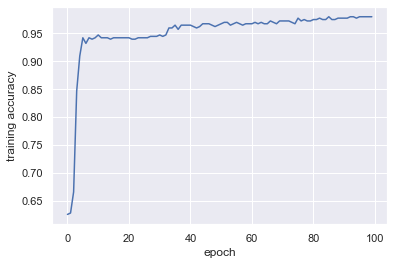

In [29]:
# plot the progress of the training over time:
plt.plot(history.history["accuracy"])
plt.gca().set(xlabel = "epoch", ylabel = "training accuracy")

We’ll test the model performance on unseen test data.

In [25]:
TF1.evaluate(X_test[cols5], y_test, verbose = 2)

6/6 - 0s - loss: 0.1321 - accuracy: 0.9591


[0.1320555955171585, 0.9590643048286438]

## (g). **Comparison of model accuracy** 

Plot the graph of the training accuracy and testing accuracy of each model.

Text(0.5, 0.98, 'The comparison of 6 Models')

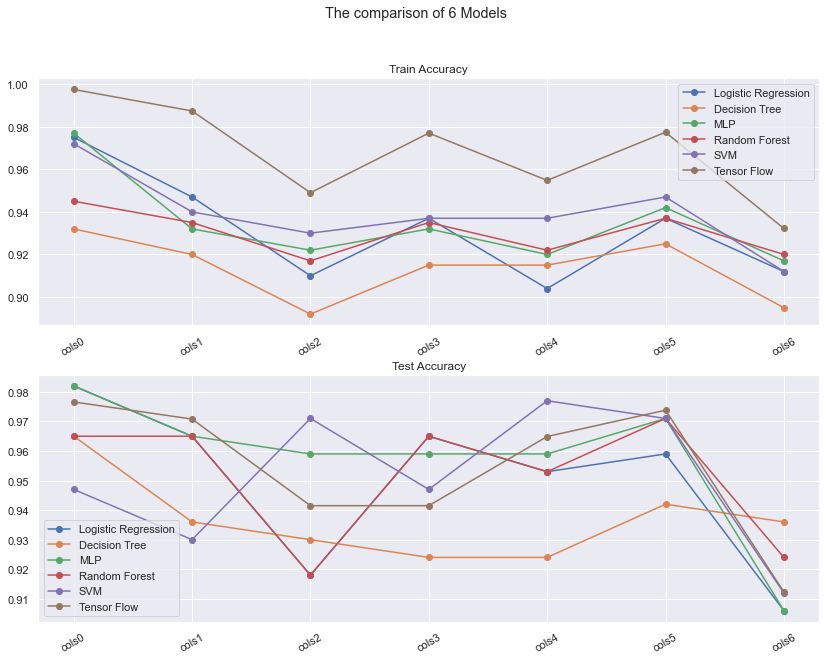

In [27]:
df1 = pd.read_csv(".\\files\\train_score.csv")
df2 = pd.read_csv(".\\files\\test_score.csv")
fig, axes = plt.subplots(2, 1,figsize=(14,10)) 
x = [0, 1, 2, 3,4,5,6]
labels = ["cols0","cols1","cols2","cols3","cols4","cols5","cols6"]
df1.plot(kind='line',marker='o',title='Train Accuracy',ax=axes[0])
df2.plot(kind='line',marker='o',title='Test Accuracy',ax=axes[1]) 
axes[0].set_xticks(x, labels, rotation=30)
axes[1].set_xticks(x, labels, rotation=30)
plt.suptitle("The comparison of 6 Models")

## My Oberserations:
（1）	We can observe from the plot that the set that contains all features has the highest accuracy in training and testing. The testing accuracy, 98.6%, is the highest using the Linear Regression model for this set. Cols1 used the 10 best features we selected using SelectKBest, and the testing accuracy is 97.06% using tensorflow. We chose 6 distinct features from cols1 to form cols3, which also has a high testing accuracy.

（2）	Cols4 is a subset of the set of the 10 best features we selected using SelectKBest which consists of the features perimeter_mean, perimeter_worst,area_mean and area_worst. From what we analyzed before we know that the perimeter and the area of a cell has high correlations with each other, so the testing accuracy of cols4 is a bit low, but its testing accuracy is very high. 

（3）	For cols5 we chose the features the area_mean,area_worst,concave.points_mean and concave.points_worst. The area of the cell and the number of its concave points have no direct correlations with each other, and they are vastly different in terms of their order of magnitude. However, after standardization, this set of features achieved very high accuracy in both testing and training. In our experiment we can see that this set of features achieved the second or third highest in accuracy using most of our machine learning models.

（4）	Cols2 chose all the mean features in cols1 but gave up on all the worst features. Cols6 only chose 2 features. Compared to other cols, their results are low in accuracy.

（5）	In these six distinct machine learning algorithms, we can see the tensorflow has the highest accuracy overall, with an accuracy of 97.66% with cols0, and an accuracy of 97.38% on cols5.

（6）	All in all, although using every one of the 30 features achieves the highest testing accuracy, in practice it is too troublesome to collect 30 features one by one. Thus we choose to use col5, which only chose 4 out of the 30 columns but still achieves high testing accuracy. In our webapp, we only type in the 4 features of cols5 and use it to make predictions using our trained machine learning algorithms. 